# XGBoost

In [33]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

cn_df = pd.read_csv('train_data/cn_price_score.csv')
us_df = pd.read_csv('train_data/us_price_score.csv')

for df in [cn_df, us_df]:
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df['sentiment_lag1'] = df['sentiment_score'].shift(1)

lags = [1, 2, 3, 4, 5, 10, 15, 20]

def create_features(df, use_sentiment=True):
    df = df.copy()
    for lag in lags:
        df[f'price_lag_{lag}'] = df['Price'].shift(lag)
    if use_sentiment:
        features = [f'price_lag_{lag}' for lag in lags] + ['sentiment_lag1']
    else:
        features = [f'price_lag_{lag}' for lag in lags]
    
    df['target_price'] = df['Price'].shift(-1)
    df = df.dropna(subset=features + ['target_price'])

    X = df[features]
    y = df['target_price']
    return X, y

def train_eval_split(X, y, ratio=0.8):
    split_idx = int(len(X) * ratio)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    model = XGBRegressor(n_estimators=50, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    return {
        "model": model,
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": mean_squared_error(y_test, preds, squared=False),
        "R2": r2_score(y_test, preds)
    }

X_cn_nosent, y_cn_nosent = create_features(cn_df, use_sentiment=False)
X_cn_sent, y_cn_sent = create_features(cn_df, use_sentiment=True)

X_us_nosent, y_us_nosent = create_features(us_df, use_sentiment=False)
X_us_sent, y_us_sent = create_features(us_df, use_sentiment=True)

results = [
    {"Country": "China", "Model": "No Sentiment", **train_eval_split(X_cn_nosent, y_cn_nosent)},
    {"Country": "China", "Model": "With Sentiment", **train_eval_split(X_cn_sent, y_cn_sent)},
    {"Country": "US", "Model": "No Sentiment", **train_eval_split(X_us_nosent, y_us_nosent)},
    {"Country": "US", "Model": "With Sentiment", **train_eval_split(X_us_sent, y_us_sent)},
]

results_df = pd.DataFrame(results)[["Country", "Model", "MAE", "RMSE", "R2"]]
print(results_df)

  Country           Model         MAE        RMSE        R2
0   China    No Sentiment   53.878147   64.982138  0.116434
1   China  With Sentiment   47.287635   58.780469  0.277035
2      US    No Sentiment  116.439393  154.656809 -1.264104
3      US  With Sentiment  106.162606  141.269175 -0.889092


/Users/janedoe/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/janedoe/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/janedoe/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/janedoe/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To cal

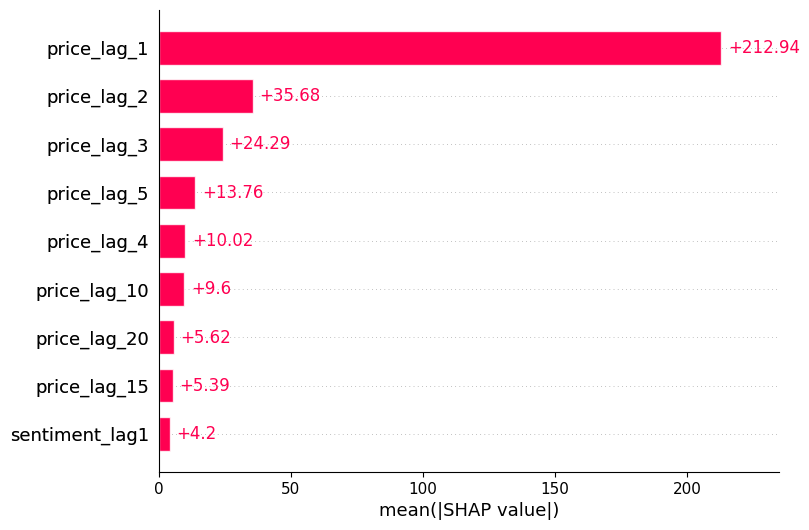

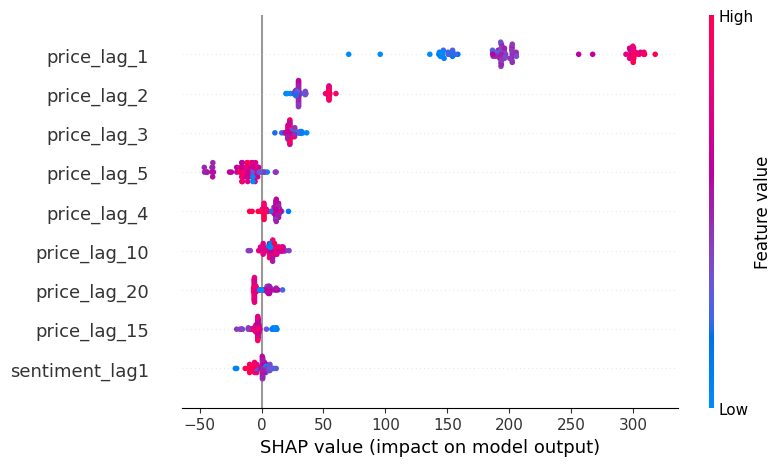

In [34]:
import shap
import matplotlib.pyplot as plt

X_cn_sent, y_cn_sent = create_features(cn_df, use_sentiment=True)

split_idx = int(len(X_cn_sent) * 0.8)
X_train = X_cn_sent.iloc[:split_idx]
y_train = y_cn_sent.iloc[:split_idx]
X_test = X_cn_sent.iloc[split_idx:]
y_test = y_cn_sent.iloc[split_idx:]

xgb_model = XGBRegressor(n_estimators=50, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

shap.plots.bar(shap_values, max_display=10)

shap.plots.beeswarm(shap_values, max_display=10)


# Random Forest

In [35]:
from sklearn.ensemble import RandomForestRegressor

def train_eval_rf(X, y, ratio=0.8):
    split_idx = int(len(X) * ratio)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    model = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    return {
        "model": model,
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": mean_squared_error(y_test, preds, squared=False),
        "R2": r2_score(y_test, preds)
    }

X_cn_nosent, y_cn_nosent = create_features(cn_df, use_sentiment=False)
X_cn_sent, y_cn_sent = create_features(cn_df, use_sentiment=True)
X_us_nosent, y_us_nosent = create_features(us_df, use_sentiment=False)
X_us_sent, y_us_sent = create_features(us_df, use_sentiment=True)

results = [
    {"Country": "China", "Model": "RF No Sentiment", **train_eval_rf(X_cn_nosent, y_cn_nosent)},
    {"Country": "China", "Model": "RF With Sentiment", **train_eval_rf(X_cn_sent, y_cn_sent)},
    {"Country": "US", "Model": "RF No Sentiment", **train_eval_rf(X_us_nosent, y_us_nosent)},
    {"Country": "US", "Model": "RF With Sentiment", **train_eval_rf(X_us_sent, y_us_sent)},
]

results_df = pd.DataFrame(results)[["Country", "Model", "MAE", "RMSE", "R2"]]
print(results_df)

/Users/janedoe/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/janedoe/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Country              Model        MAE        RMSE        R2
0   China    RF No Sentiment  51.100118   62.496086  0.182747
1   China  RF With Sentiment  49.710406   62.604946  0.179897
2      US    RF No Sentiment  96.978457  129.773144 -0.594145
3      US  RF With Sentiment  96.124375  128.701986 -0.567937


/Users/janedoe/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/janedoe/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


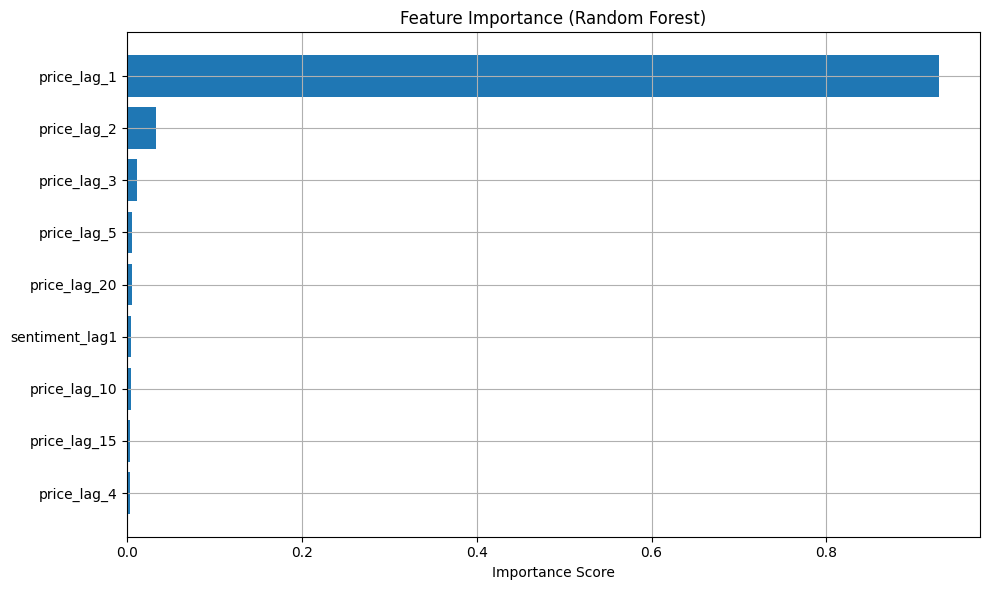

In [37]:
X_cn_sent, y_cn_sent = create_features(cn_df, use_sentiment=True)
split_idx = int(len(X_cn_sent) * 0.8)
X_train = X_cn_sent.iloc[:split_idx]
y_train = y_cn_sent.iloc[:split_idx]
X_test = X_cn_sent.iloc[split_idx:]

model = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
model.fit(X_train, y_train)


importances = model.feature_importances_
feature_names = X_train.columns
importances_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(importances_df["Feature"], importances_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.grid(True)
plt.tight_layout()
plt.show()


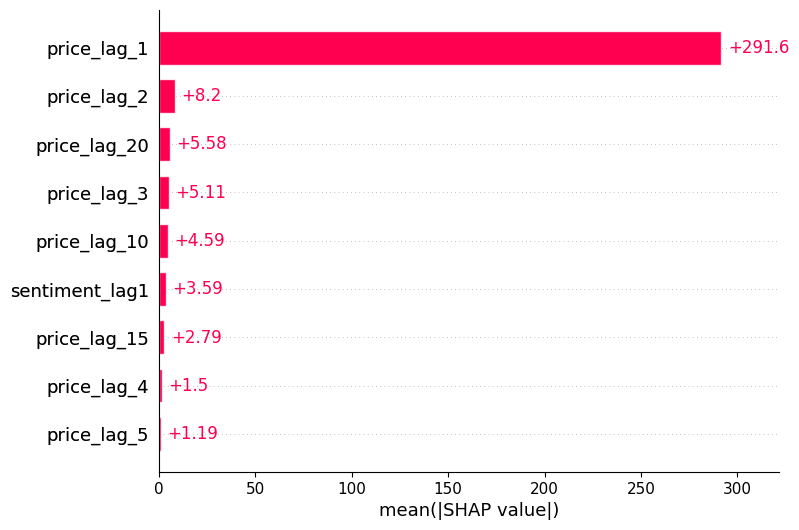

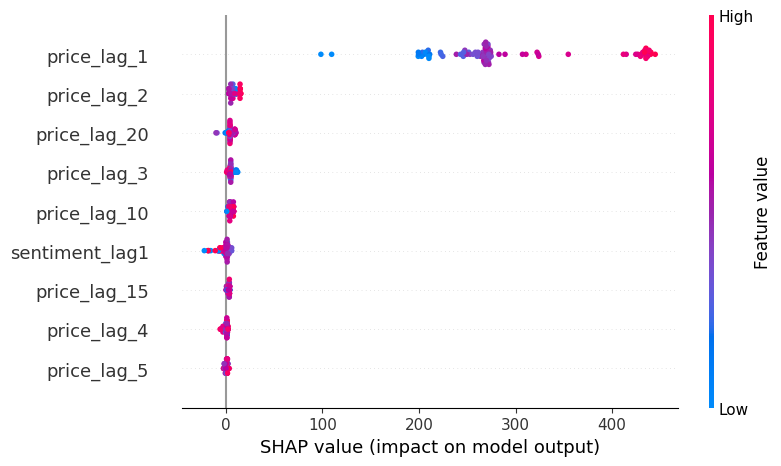

In [38]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

shap.plots.bar(shap_values, max_display=10)

shap.plots.beeswarm(shap_values, max_display=10)